In [1]:
# Load Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

In [2]:
# Load data
df = pd.read_csv('NFL_Game_Data.csv')

In [3]:
df.head()

,Date,Week,Day,Time,HomeTeam,AwayTeam,HomePoints,AwayPoints,HomeYards,AwayYards,...,Away_Avg_YardsAllowed,Away_Avg_TurnoversForced,Away_WinRate,WinRate_Diff,Avg_Points_Diff,Avg_Yards_Diff,Avg_Turnovers_Diff,Avg_PointsAllowed_Diff,Avg_YardsAllowed_Diff,Avg_TurnoversForced_Diff
0,2017-10-19,7,Thu,8:25PM,Las Vegas Raiders,Kansas City Chiefs,31,30,505,425,...,378.17,1.33,0.83,-0.50,-8.83,-108.67,1.00,-0.67,-28.33,-0.50
1,2017-10-22,7,Sun,1:00PM,Minnesota Vikings,Baltimore Ravens,24,16,357,208,...,330.83,2.33,0.50,0.17,1.33,66.83,-1.00,-3.50,-35.33,-1.00
2,2017-10-22,7,Sun,1:00PM,Los Angeles Rams,Arizona Cardinals,33,0,425,196,...,340.33,1.00,0.50,0.17,10.00,3.83,0.33,-3.33,9.83,0.67
3,2017-10-22,7,Sun,1:00PM,Chicago Bears,Carolina Panthers,17,3,153,293,...,280.00,0.67,0.67,-0.33,-3.83,-16.67,0.67,4.33,22.67,0.33
4,2017-10-22,7,Sun,1:00PM,Indianapolis Colts,Jacksonville Jaguars,0,27,232,518,...,311.67,2.67,0.50,-0.17,-6.17,-34.33,0.50,14.17,98.33,-1.33


In [4]:
# Drop outcome-related columns to avoid leakage
cols_to_drop = [
    'HomePoints', 'AwayPoints', 'HomeYards', 'AwayYards',
    'HomeTurnovers', 'AwayTurnovers', 'HomeWin',
    'HomeTeam', 'AwayTeam', 'Date', 'Week', 'Day', 'Time',
    'Home_Team_Name', 'Away_Team_Name'
]

# Define X and Y
X = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
y = df['HomeWin']

# Save feature names
feature_cols = X.columns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test,
# then rewrap as DataFrames to preserve feature names
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_cols)

# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Run and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



Logistic Regression
              precision    recall  f1-score   support

           0      0.566     0.445     0.498       164
           1      0.636     0.740     0.684       215

    accuracy                          0.612       379
   macro avg      0.601     0.592     0.591       379
weighted avg      0.606     0.612     0.604       379

Confusion Matrix:
[[ 73  91]
 [ 56 159]]

Random Forest
              precision    recall  f1-score   support

           0      0.553     0.506     0.529       164
           1      0.646     0.688     0.667       215

    accuracy                          0.609       379
   macro avg      0.600     0.597     0.598       379
weighted avg      0.606     0.609     0.607       379

Confusion Matrix:
[[ 83  81]
 [ 67 148]]


In [5]:
# Models to tune
tuning_models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Hyperparameters for tuning
param_grid = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'max_depth': [5, 10, 15, 20],
        'max_features': ['sqrt', 'log2', None],
        'min_samples_leaf': [1, 2, 5],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 200]
    }
}

# Using GridSearchCV to tune both models
best_models = {}

for model_name, model in tuning_models.items():
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

Best parameters for Logistic Regression: {'C': 0.01, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.6175616899438288
Best parameters for Random Forest: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: 0.622850960592748


In [6]:
# Make predictions
log_reg_predictions = best_models['Logistic Regression'].predict(X_test)
rf_predictions = best_models['Random Forest'].predict(X_test)

# Evaluate predictions
print("Logistic Regression Evaluation:")
print(classification_report(y_test, log_reg_predictions))
print(confusion_matrix(y_test, log_reg_predictions))

print("\nRandom Forest Evaluation:")
print(classification_report(y_test, rf_predictions))
print(confusion_matrix(y_test, rf_predictions))


Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.58      0.48      0.52       164
           1       0.65      0.73      0.69       215

    accuracy                           0.62       379
   macro avg       0.61      0.61      0.61       379
weighted avg       0.62      0.62      0.62       379

[[ 79  85]
 [ 58 157]]

Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       164
           1       0.66      0.72      0.68       215

    accuracy                           0.63       379
   macro avg       0.62      0.61      0.61       379
weighted avg       0.62      0.63      0.62       379

[[ 83  81]
 [ 61 154]]


WIll use Random Forest as it has a slightly higher accuracy, more a balanced performance between classes and is less prone to overfitting.

In [7]:
# Check class distribution in the entire dataset
print("Overall Class Balance:")
print(df['HomeWin'].value_counts(normalize=True))
print(df['HomeWin'].value_counts())

Overall Class Balance:
HomeWin
1    0.552562
0    0.447438
Name: proportion, dtype: float64
HomeWin
1    1046
0     847
Name: count, dtype: int64


In [8]:
# Try Class Weighting to pay more attention to under represented class (home loss)
rf_weighted = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_weighted.fit(X_train, y_train)
y_pred_weighted = rf_weighted.predict(X_test)

print(classification_report(y_test, y_pred_weighted))

              precision    recall  f1-score   support

           0       0.56      0.54      0.55       164
           1       0.66      0.68      0.67       215

    accuracy                           0.62       379
   macro avg       0.61      0.61      0.61       379
weighted avg       0.62      0.62      0.62       379



In [9]:
# Use the best Random Forest model with the best parameters from GridSearchCV
rf_weighted_best = best_models['Random Forest']

# Add class weighting
rf_weighted_best.class_weight = 'balanced'

# Fit the model
rf_weighted_best.fit(X_train, y_train)

# Make predictions
y_pred_weighted_best = rf_weighted_best.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred_weighted_best))


              precision    recall  f1-score   support

           0       0.52      0.60      0.56       164
           1       0.66      0.58      0.62       215

    accuracy                           0.59       379
   macro avg       0.59      0.59      0.59       379
weighted avg       0.60      0.59      0.59       379



Using unweighted model as there is only a slight class imbalance

In [10]:
season_2024 = pd.read_csv("NFL_2024_Season_Subset.csv")
season_2024.head()

,Date,Week,Day,Time,HomeTeam,AwayTeam,HomePoints,AwayPoints,HomeYards,AwayYards,...,Away_Avg_YardsAllowed,Away_Avg_TurnoversForced,Away_WinRate,WinRate_Diff,Avg_Points_Diff,Avg_Yards_Diff,Avg_Turnovers_Diff,Avg_PointsAllowed_Diff,Avg_YardsAllowed_Diff,Avg_TurnoversForced_Diff
0,2024-11-07,10,Thu,8:15PM,Baltimore Ravens,Cincinnati Bengals,35,34,389,470,...,359.00,1.17,0.67,0.17,7.33,121.17,-0.33,-1.00,5.00,-0.17
1,2024-11-10,10,Sun,1:00PM,Chicago Bears,New England Patriots,3,19,142,328,...,378.50,1.00,0.17,0.33,5.50,60.00,-0.83,-8.00,-40.33,0.83
2,2024-11-10,10,Sun,9:30AM,Carolina Panthers,New York Giants,20,17,306,342,...,321.83,0.83,0.33,-0.17,-2.33,-63.33,0.50,12.17,89.50,-0.17
3,2024-11-10,10,Sun,1:00PM,Washington Commanders,Pittsburgh Steelers,27,28,242,312,...,326.83,1.67,0.67,0.17,4.67,57.33,-0.33,-0.33,-26.00,-0.50
4,2024-11-10,10,Sun,1:00PM,New Orleans Saints,Atlanta Falcons,20,17,365,468,...,363.83,1.33,0.83,-0.83,-13.83,-82.00,-0.17,-1.00,10.83,-0.33


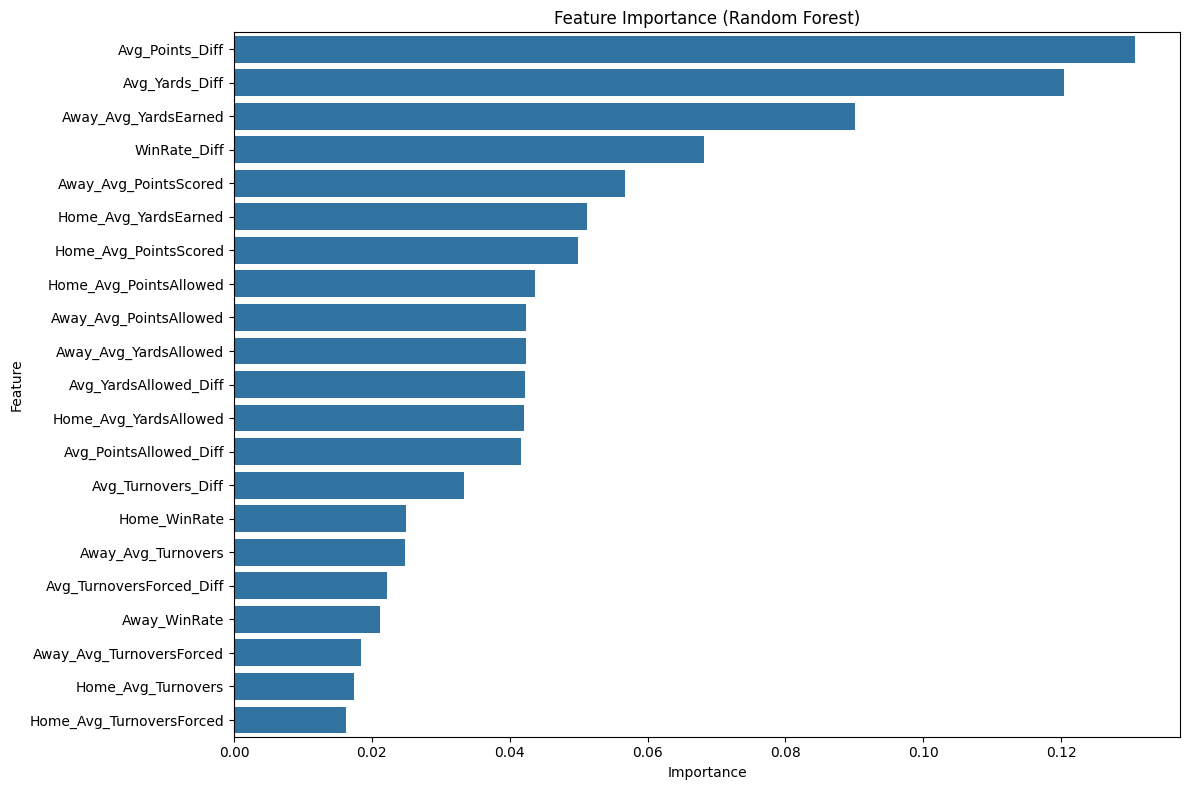

In [12]:
# Get the best Random Forest model
rf_best = best_models['Random Forest']

# Create a DataFrame for feature importances
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [13]:
# Print feature importance
print(importances)

                     Feature  Importance
15           Avg_Points_Diff    0.130706
16            Avg_Yards_Diff    0.120429
8       Away_Avg_YardsEarned    0.090034
14              WinRate_Diff    0.068233
7      Away_Avg_PointsScored    0.056742
1       Home_Avg_YardsEarned    0.051203
0      Home_Avg_PointsScored    0.049864
3     Home_Avg_PointsAllowed    0.043621
10    Away_Avg_PointsAllowed    0.042429
11     Away_Avg_YardsAllowed    0.042410
19     Avg_YardsAllowed_Diff    0.042161
4      Home_Avg_YardsAllowed    0.042131
18    Avg_PointsAllowed_Diff    0.041614
17        Avg_Turnovers_Diff    0.033432
6               Home_WinRate    0.024890
9         Away_Avg_Turnovers    0.024776
20  Avg_TurnoversForced_Diff    0.022141
13              Away_WinRate    0.021231
12  Away_Avg_TurnoversForced    0.018377
2         Home_Avg_Turnovers    0.017365
5   Home_Avg_TurnoversForced    0.016211


Predict 2024 season subet using RF model

In [14]:
# Define feature columns
feature_columns = [
    'Home_Avg_PointsScored', 'Away_Avg_PointsScored',
    'Home_Avg_YardsEarned', 'Away_Avg_YardsEarned',
    'Home_Avg_Turnovers', 'Away_Avg_Turnovers',
    'Home_WinRate', 'Away_WinRate',
    'WinRate_Diff', 'Avg_Points_Diff', 'Avg_Yards_Diff', 'Avg_Turnovers_Diff',
    'Home_Avg_PointsAllowed', 'Away_Avg_PointsAllowed',
    'Home_Avg_YardsAllowed', 'Away_Avg_YardsAllowed',
    'Home_Avg_TurnoversForced', 'Away_Avg_TurnoversForced',
    'Avg_PointsAllowed_Diff', 'Avg_YardsAllowed_Diff', 'Avg_TurnoversForced_Diff'
]

In [15]:
# Ensure X_train and X_test are DataFrames before scaling
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_2024 = season_2024[feature_columns]

# Ensure column order and names match the scaled training data
X_2024 = X_2024[X_train.columns]

# Now scale the new data using the already-fitted scaler
X_2024_scaled = scaler.transform(X_2024)


In [16]:
# Make predictions using the Random Forest model
rf_predictions_2024 = best_models['Random Forest'].predict(X_2024_scaled)

# See the predicted outcomes:
season_2024['Predicted_HomeWin'] = rf_predictions_2024

# Display the results for the 2024 season predictions
season_2024[['HomeTeam', 'AwayTeam', 'Predicted_HomeWin', 'HomeWin']].head(15)


/Users/jonathan/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,HomeTeam,AwayTeam,Predicted_HomeWin,HomeWin
0,Baltimore Ravens,Cincinnati Bengals,1,1
1,Chicago Bears,New England Patriots,1,0
2,Carolina Panthers,New York Giants,0,1
3,Washington Commanders,Pittsburgh Steelers,1,0
4,New Orleans Saints,Atlanta Falcons,0,1
5,Indianapolis Colts,Buffalo Bills,0,0
6,Kansas City Chiefs,Denver Broncos,1,1
7,Jacksonville Jaguars,Minnesota Vikings,0,0
8,Los Angeles Chargers,Tennessee Titans,1,1
9,Dallas Cowboys,Philadelphia Eagles,0,0


In [17]:
# Print rate of correctly id wins/losses
accuracy = (season_2024['Predicted_HomeWin'] == season_2024['HomeWin']).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.67


In [20]:
season_2024[['HomeTeam', 'AwayTeam', 'Predicted_HomeWin', 'HomeWin']]

,HomeTeam,AwayTeam,Predicted_HomeWin,HomeWin
0,Baltimore Ravens,Cincinnati Bengals,1,1
1,Chicago Bears,New England Patriots,1,0
2,Carolina Panthers,New York Giants,0,1
3,Washington Commanders,Pittsburgh Steelers,1,0
4,New Orleans Saints,Atlanta Falcons,0,1
...,...,...,...,...
136,Detroit Lions,Washington Commanders,0,0
137,Buffalo Bills,Baltimore Ravens,0,1
138,Philadelphia Eagles,Los Angeles Rams,1,1
139,Kansas City Chiefs,Buffalo Bills,0,1


In [21]:
season_2024[
    (season_2024['HomeTeam'] == 'Detroit Lions') | (season_2024['AwayTeam'] == 'Detroit Lions')
][['HomeTeam', 'AwayTeam', 'Predicted_HomeWin', 'HomeWin']]


,HomeTeam,AwayTeam,Predicted_HomeWin,HomeWin
11,Houston Texans,Detroit Lions,0,0
38,Indianapolis Colts,Detroit Lions,0,0
40,Detroit Lions,Chicago Bears,1,1
56,Detroit Lions,Green Bay Packers,1,1
87,Chicago Bears,Detroit Lions,0,0
113,San Francisco 49ers,Detroit Lions,0,0
120,Detroit Lions,Minnesota Vikings,0,1
136,Detroit Lions,Washington Commanders,0,0


In [22]:
# Create a new column indicating whether the prediction was correct
season_2024['Correct'] = season_2024['Predicted_HomeWin'] == season_2024['HomeWin']

# Get all team names from both home and away columns
teams = pd.unique(season_2024[['HomeTeam', 'AwayTeam']].values.ravel())

# Initialize a list to store results
team_results = []

# Loop through each team
for team in teams:
    team_games = season_2024[
        (season_2024['HomeTeam'] == team) | (season_2024['AwayTeam'] == team)
    ]
    correct_predictions = team_games['Correct'].sum()
    total_games = len(team_games)
    accuracy = correct_predictions / total_games if total_games > 0 else 0

    team_results.append({
        'Team': team,
        'Games': total_games,
        'Correct Predictions': correct_predictions,
        'Accuracy': round(accuracy, 3)
    })

# Convert to DataFrame for display
team_accuracy_df = pd.DataFrame(team_results).sort_values(by='Accuracy', ascending=False)
print(team_accuracy_df)

                     Team  Games  Correct Predictions  Accuracy
29      Las Vegas Raiders      8                    7     0.875
23          Detroit Lions      8                    7     0.875
8      New Orleans Saints      8                    7     0.875
30       Cleveland Browns      7                    6     0.857
0        Baltimore Ravens     10                    8     0.800
12     Kansas City Chiefs     10                    8     0.800
24   Tampa Bay Buccaneers      9                    7     0.778
2           Chicago Bears      9                    7     0.778
25    San Francisco 49ers      9                    7     0.778
21          New York Jets      8                    6     0.750
19    Philadelphia Eagles     12                    9     0.750
1      Cincinnati Bengals      7                    5     0.714
7     Pittsburgh Steelers     10                    7     0.700
15      Minnesota Vikings     10                    7     0.700
27         Miami Dolphins      9        

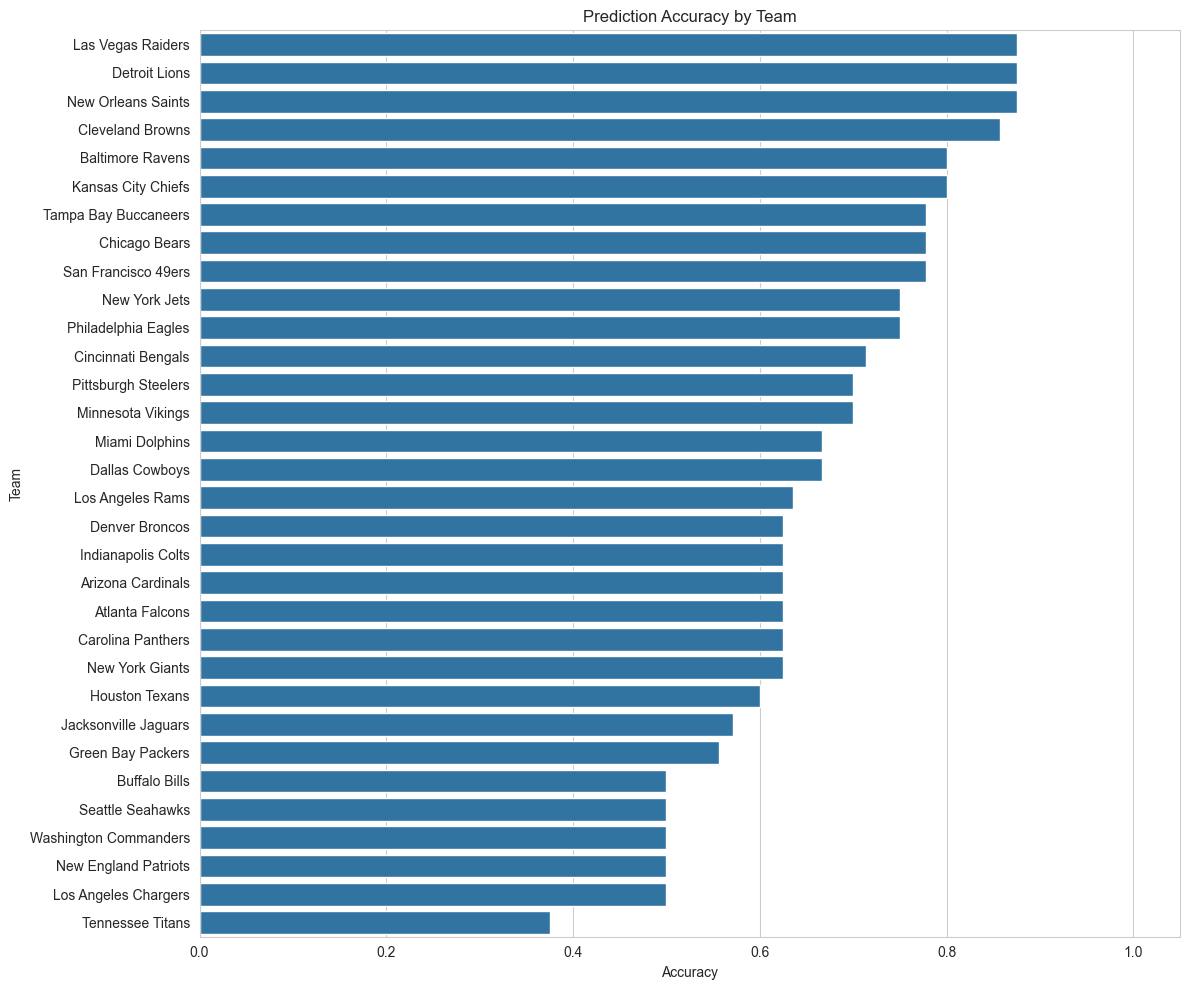

In [23]:
# Sort by accuracy for clean plotting
team_accuracy_df_sorted = team_accuracy_df.sort_values(by='Accuracy', ascending=False)

# Plot setup
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Create horizontal bar plot
sns.barplot(
    x='Accuracy',
    y='Team',
    data=team_accuracy_df_sorted,
)

# Labels and formatting
plt.title('Prediction Accuracy by Team')
plt.xlabel('Accuracy')
plt.ylabel('Team')
plt.xlim(0, 1.05)  # Accuracy goes from 0 to 1
plt.tight_layout()
plt.show()

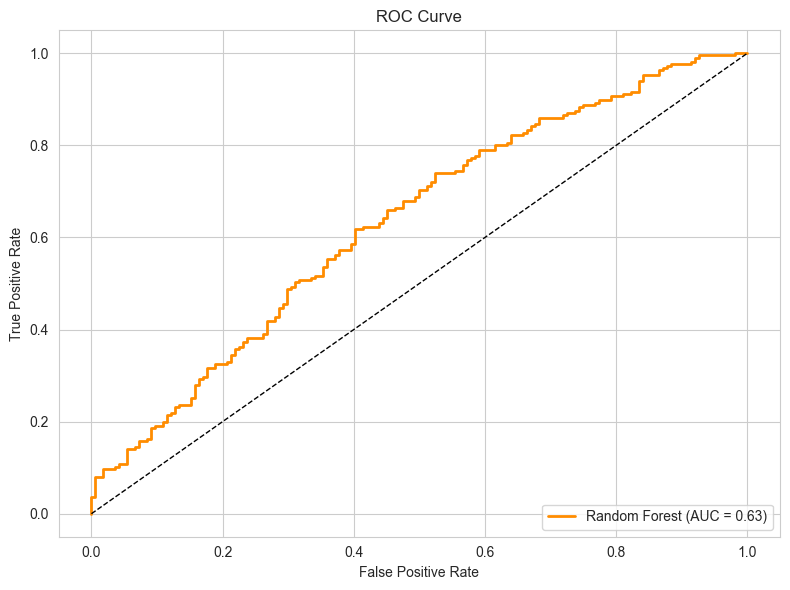

In [24]:
# Get predicted probabilities for the positive class (HomeWin = 1)
y_probs = rf_best.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line (random guessing)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()